This notebooks compares the execution times of new and old posprocessing methods.
It generates fake data to run the postprocessing.

In [49]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import sys
sys.path.append('../..')
from src import postprocessing as pp


# Parameters
num_days = 100
num_patients = 100
sample_freq = '5T'  # 5 minutes

# Generate datetime range for each day with a gap of 4 hours
def generate_datetime_range(start_date, num_days, sample_freq):
    date_ranges = []
    start = start_date
    end = start
    while (end-start) < timedelta(days=num_days):
        a = end + timedelta(hours=np.random.randint(1, 12))
        end = a + timedelta(hours=np.random.randint(1, 12))
        date_ranges.append(pd.date_range(a, end, freq=sample_freq))
    return pd.DatetimeIndex(np.concatenate(date_ranges))

# Generate sine curve CGM values
def generate_cgm_values(num_samples):
    x = np.linspace(0, 2 * np.pi, num_samples)
    return 100 + 20 * np.sin(x)  # Sine curve with mean 100 and amplitude 20

# Generate data for each patient
data = []
start_date = datetime(2023, 1, 1)
for patient_id in range(1, num_patients + 1):
    datetimes = generate_datetime_range(start_date, num_days, sample_freq)
    cgm_values = np.array([75 + 50 * (1+np.sin((x-datetimes.min()).total_seconds() / (24*3600))) for x in datetimes])
    cgm_values = cgm_values + np.random.normal(0, 5, len(cgm_values))
    
    patient_data = pd.DataFrame({
        'datetime': datetimes,
        'patient_id': [f'Patient_{patient_id}'] * len(datetimes),
        'cgm': cgm_values
    })
    data.append(patient_data)

# Concatenate all patient data into a single DataFrame
df = pd.concat(data).reset_index(drop=True)

# from matplotlib import pyplot as plt
# f, ax = plt.subplots(figsize=(12, 2))
# for patient_id, group in df.groupby('patient_id'):
#     ax.scatter(x=group.datetime, y=group.cgm, label=patient_id,marker='.',s=1)
#     #break

# ax.set_title('CGM values for 4 patients over 25 days')
# plt.legend(title='Patient ID')
# plt.show()

/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_40197/686802688.py:24: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  date_ranges.append(pd.date_range(a, end, freq=sample_freq))


In [7]:
#old versions of posprocessing functions
import time
def cgm_transform_old(cgm_data):
    """
    Time aligns the cgm data to midnight with a 5 minute sampling rate.

    Parameters:
        cgm_data (DataFrame): The input is a cgm data dataframe containing columns 'patient_id, 'datetime', and 'cgm'.

    Returns:
        cgm_data (DataFrame): The transformed cgm data with aligned timestamps.
    """
    #start data from midnight
    cgm_data = cgm_data.sort_values(by='datetime').reset_index(drop=True)
    cgm_data['datetime'] = cgm_data['datetime'].dt.round("5min")
    cgm_data['UnixTime'] = [int(time.mktime(cgm_data.datetime[x].timetuple())) for x in cgm_data.index]

    start_date = cgm_data['datetime'].iloc[0].date()
    end_date = cgm_data['datetime'].iloc[-1].date() + timedelta(days=1)
    
    cgm_from_mid = pd.DataFrame(columns=['datetime_adj'])
    cgm_from_mid['datetime_adj'] = pd.date_range(start = start_date, end = end_date, freq="5min").values

    cgm_from_mid['UnixTime'] = [int(time.mktime(cgm_from_mid.datetime_adj[x].timetuple())) for x in cgm_from_mid.index]
    cgm_from_mid = cgm_from_mid.drop_duplicates(subset=['UnixTime']).sort_values(by='UnixTime')
    cgm_data = cgm_data.drop_duplicates(subset=['UnixTime']).sort_values(by='UnixTime')

    #merge new time with cgm data
    cgm_merged = pd.merge_asof(cgm_from_mid, cgm_data, on="UnixTime",direction="nearest",tolerance=149)

    cgm_data = cgm_merged.filter(items=['datetime_adj','cgm'])
    cgm_data = cgm_data.rename(columns={"datetime_adj": "datetime"}) 
    
    #replace not null values outside of 40-400 range with 40 or 400
    cgm_data.loc[cgm_data['cgm'] < 40, 'cgm'] = 40
    cgm_data.loc[cgm_data['cgm'] > 400, 'cgm'] = 400
    
    return cgm_data

In [50]:
from line_profiler import LineProfiler
lp = LineProfiler()
lp.add_function(pp.cgm_transform)
lp.add_function(cgm_transform_old)

lp_wrapper = lp(df.groupby('patient_id').apply)
res= lp_wrapper(pp.cgm_transform, include_groups=False)
res_old = lp_wrapper(cgm_transform_old, include_groups=False)

# Calculate and print the difference in total execution times
stats = lp.get_stats()
for key in stats.timings.keys():
    #print(sum([t[2] for t in stats.timings[key]]))
    print(key[0])
    print(f'Execution time {sum([t[2] for t in stats.timings[key]])/1000000000:.6f} seconds')

/Users/jan/git/nudgebg/egvinsulin/notebooks/understand-dana-dataset/../../src/postprocessing.py
Execution time 0.590210 seconds
/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_40197/1087713417.py
Execution time 75.299465 seconds
/Users/jan/.pyenv/versions/3.9.6/envs/nudgebg/lib/python3.9/site-packages/pandas/core/groupby/groupby.py
Execution time 76.033179 seconds


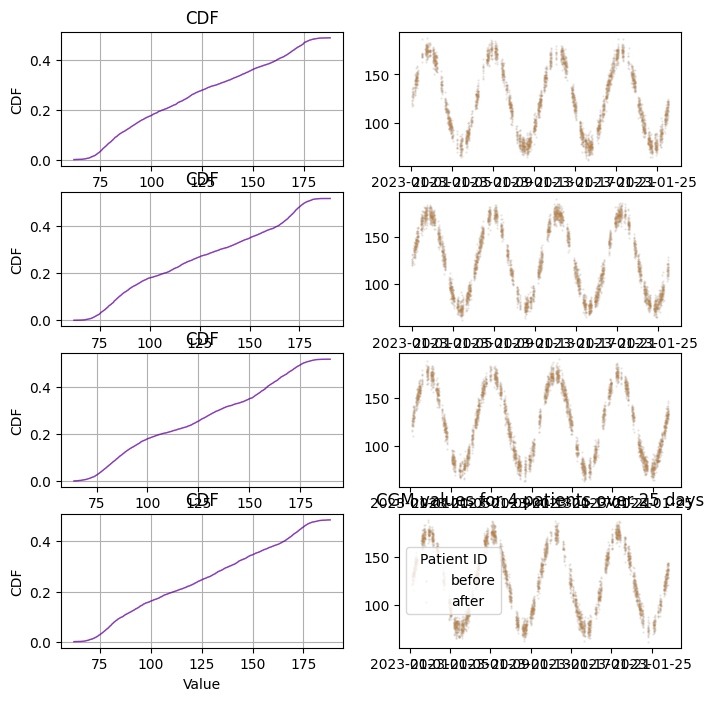

In [ ]:
from src import cdf
import importlib
importlib.reload(cdf)

f,AX = plt.subplots(4,2,figsize=(8, 8),sharex=False)
#AX = AX.flatten()

for i,patient_id in enumerate(df.patient_id.unique()):
    ax = AX[i,0]
    res_sub = res.loc[patient_id]
    res_old_sub = res_old.loc[patient_id]
    cdf.plot_cdf(res_sub.cgm,ax=ax,label='new',color='red',alpha=0.5,marker='')
    cdf.plot_cdf(res_old_sub.cgm,ax=ax,label='old',color='blue',alpha=0.5,marker='')

    # ax = AX[i,1]
    # ax.scatter(x=res_sub.datetime, y=res_sub.cgm, label='before',marker='.',s=1,alpha=0.1)
    # ax.scatter(x=res_old_sub.datetime, y=res_old_sub.cgm, label='after',marker='.',s=1,alpha=0.1)
    #ax.scatter(x=res_sub.datetime[res_sub.cgm.isna()], y=[0]*res_sub.cgm.isna().sum(), color='red', label='NaN values', marker='x', s=1)

ax.set_title('CGM values for 4 patients over 25 days')
plt.legend(title='Patient ID')
plt.show()
